In [42]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

# sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

nb_prefix = "180711"

Loading BokehJS ...

In [43]:
chan_ind = ['0','3','5']
channel = ['Brightfield', 'mScarlet', 'sfCFP']
chan_dict = dict(zip(chan_ind, channel))

# epoch_zero = 1518161340

def img_metadata_dict(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image_2(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Make the structuring element
    selem = skimage.morphology.square(2)
    # Perform the median filter
    im_filt = skimage.filters.median(im_arr, selem)

    # Convert the uneven image to floating point
    im_float = im_filt / 4096
    # Smooth to reduce noise
    g_radius = 10
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
#     im_edge = skimage.filters.sobel(im_bgsub)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    thresh = skimage.filters.threshold_otsu(im_edge)
    im_bw = ndi.morphology.binary_fill_holes(im_edge > thresh)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)

    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(img):
    im_labeled, num = label_image(img[:,:,:2].sum(axis=2))
    gfp, rfp = crop(img[:,:,1]), crop(img[:,:,0])
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    h, w = gfp.shape
    x1,x2,y1,y2 = np.int(7*w/8),w,0,np.int(1*h/8)
    gfp_bg = np.mean(gfp[y1:y2,x1:x2])
    rfp_bg = np.mean(rfp[y1:y2,x1:x2])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def get_fluors_2(rfp, gfp):
    im_labeled, num = label_image(rfp+gfp)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg, im_labeled

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [12]:
with skimage.external.tifffile.TiffFile('180711_fullmovie_masktry.tif') as img:
    im_all = img.asarray(memmap=True)

# with skimage.external.tifffile.TiffFile('180711_fullmovie_masksonly.tif') as img:
#     im_masks = img.asarray(memmap=True)
    
t_df = pd.read_csv('{}_time.csv'.format(nb_prefix))

In [8]:
allpos_dict['POSITIONS'][0]['LABEL']

'Pos0'

In [8]:
import ast
with open('exp_points.pos') as f:
    lines = f.read()
    allpos_dict = ast.literal_eval(lines)
prox_df = pd.DataFrame(np.zeros((4,3)), columns=['X', 'Y', 'pad'])
x = []
y = []
pad = []
i = 0
for pos_dict in allpos_dict['POSITIONS']:
    if pos_dict['LABEL'] in ['Pos0', 'Pos1', 'Pos2', 'Pos17']:
        x.append(pos_dict['DEVICES'][1]['X'])
        y.append(pos_dict['DEVICES'][1]['Y'])
        pad.append(i)
        i += 1
prox_df = pd.DataFrame(dict(zip(['X', 'Y', 'pad'], [x, y, pad])))
print(prox_df)

         X        Y  pad
0  26626.7 -11132.1    0
1  15924.1 -14105.1    1
2  31708.3  -4804.0    2
3  28446.9   5539.2    3


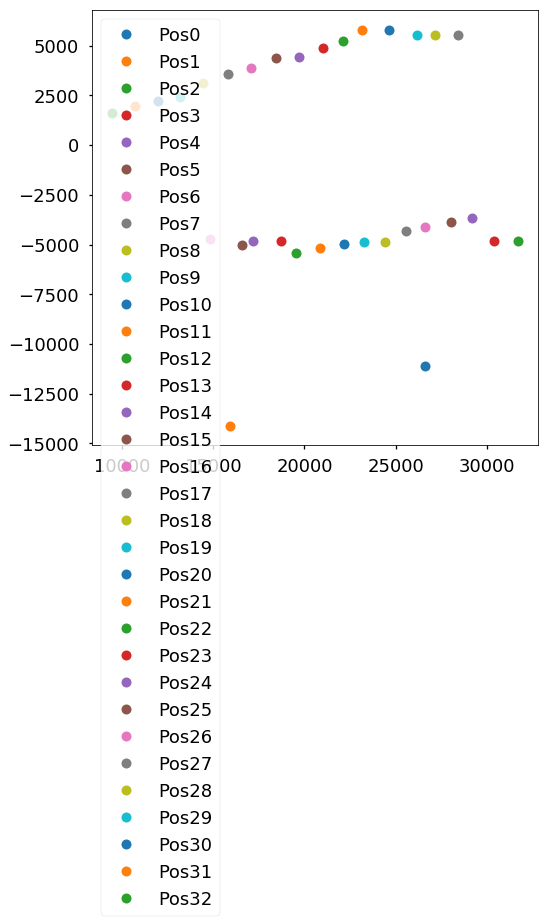

In [11]:
fn = "img_000000000_0_000.tif"
all_metadata = fn_metadata_full(fn)
summ_dict = all_metadata['Summary']
n_p = len(summ_dict['InitialPositionList'])

# all_pos_df = pd.DataFrame(np.empty((n_p,3)),columns=['x','y','label'])
# for p_i in np.arange(n_p):
#     sub_dict = all_dict['POSITIONS'][p_i]['DEVICES'][1]
#     x = np.float(sub_dict['X'])
#     y = np.float(sub_dict['Y'])
#     label = all_dict['POSITIONS'][p_i]['LABEL']
#     all_pos_df.loc[p_i,['x', 'y', 'label']] = [x, y, label]

cor_pos_df = pd.DataFrame(np.empty((n_p,5)),columns=['x','y','label', 'pos', 'pad'])
for p_i in np.arange(n_p):
    x, y = summ_dict['InitialPositionList'][p_i]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][p_i]['Label']
#     if label[:2] == 'p0':
#         prox_position = all_pos_df.loc[all_pos_df.label == 'p1_proxend', ['x', 'y']]
#         x = x - prox_position.x
#         y = y - prox_position.y
#     if label[:2] == 'p1':
#         prox_position = all_pos_df.loc[all_pos_df.label == 'p2_proxend', ['x', 'y']]
#         x = x - prox_position.x
#         y = y - prox_position.y
#     if label[:2] == 'p2':
#         prox_position = all_pos_df.loc[all_pos_df.label == 'p3_proxend', ['x', 'y']]
#         x = x - prox_position.x
#         y = y - prox_position.y
    cor_pos_df.loc[p_i,['x', 'y', 'label', 'pos']] = [x, y, label, p_i]
x = []
plt.figure(figsize=(8,8))
for p_i in np.arange(n_p):
    plt.plot(np.float(cor_pos_df.x[p_i]), np.float(cor_pos_df.y[p_i]), '.', label=cor_pos_df.label[p_i],ms=20)
# plt.plot(pos_df.x, pos_df.y, '.')
plt.legend()
type(x)
cor_pos_df.loc[0, 'pad'] = 0
cor_pos_df.loc[1, 'pad'] = 1
cor_pos_df.loc[2:17, 'pad'] = 2
cor_pos_df.loc[17:, 'pad'] = 3

def dist_f(xx):
    pos_xy = cor_pos_df.loc[xx, ['x', 'y']].values
    prox_xy = prox_df.loc[cor_pos_df.loc[xx,"pad"], ["X", "Y"]].values
    return np.sqrt(np.sum(np.power(pos_xy - prox_xy, 2)))

dist_vec = np.array([dist_f(xx) for xx in np.arange(len(cor_pos_df))])
cor_pos_df['dist'] = dist_vec

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


float64
204


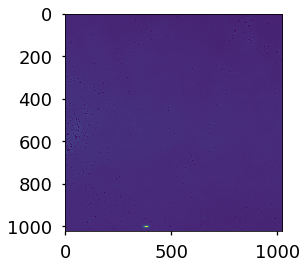

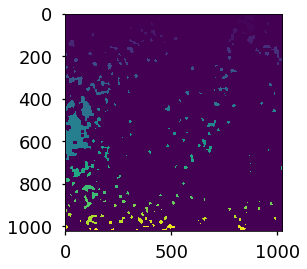

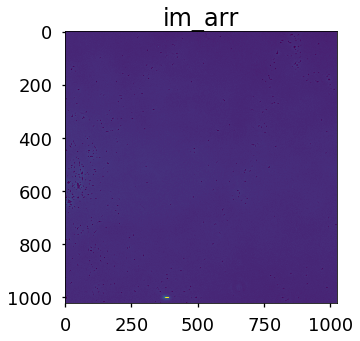

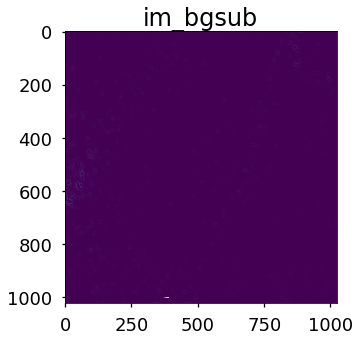

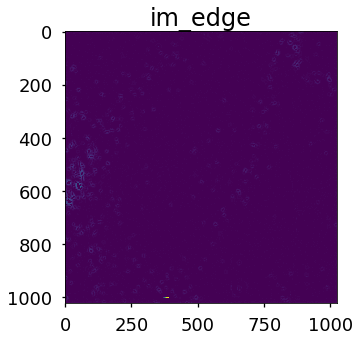

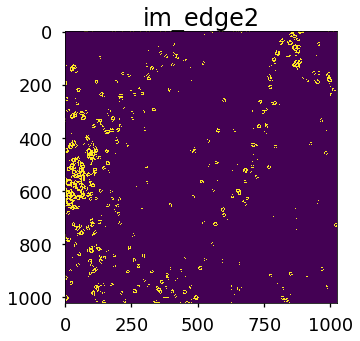

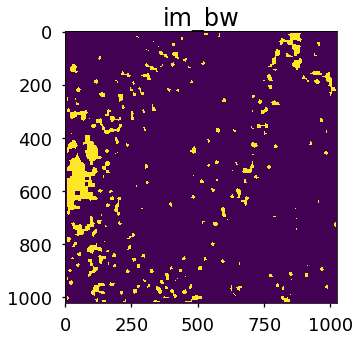

In [102]:
# with skimage.external.tifffile.TiffFile('180522_fullmovie_masktry.tif') as img:
#     im_all = img.asarray(memmap=True)


t = 5
s = 16
im_arr = im_all[t,s,0,:,:] #.sum(axis=0)# - im_all[0,12,1:,:,:].sum(axis=0)
plt.imshow(im_arr)
plt.figure()
# im_arr = im_arr.max() - im_arr
# im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
#     im_arr = im_arr.astype(np.float32).astype(np.uint16)
im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
#     im_arr[800:830,190:210]=im_arr.mean()
#     im_arr = im_arr[200:400,200:400]
#     im_arr = im_arr / im_arr.mean()
w, h = im_arr.shape

# Make the structuring element
# selem = skimage.morphology.square(2)
# Perform the median filter
# im_filt = skimage.filters.median(im_arr, selem)
# im_filt_thresh = np.power(im_filt.min() - im_filt,2)

# Convert the uneven image to floating point
im_float = im_arr
# Smooth to reduce noise
g_radius = 5
im_smooth = skimage.filters.gaussian(im_float, g_radius)
im_bgsub = im_float - im_smooth

# Perform the median filter
selem = skimage.morphology.square(4)
im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0

# thresh_factor = 0.1

# # threshold
# im_boxed = im_bgsub > thresh_factor*im_bgsub.max()

# Adjust exposure
im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

# Edge detection
im_edge = skimage.filters.sobel(im_adj)
im_edge = skimage.exposure.equalize_adapthist(im_adj)
# im_edge2 = skimage.filters.gaussian(im_edge, 20)

# Remove small objects and fill holes
thresh = skimage.filters.threshold_otsu(im_edge)
selem = skimage.morphology.square(2)
im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
selem = skimage.morphology.square(12)
im_bw = skimage.morphology.binary_closing(im_bw, selem)
# im_bw = (im_bw ^ (im_edge > thresh)) > 0
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
im_labeled, num = skimage.morphology.label(im_bw, return_num=True)

# im_bw = skimage.segmentation.random_walker(im_bw, im_labeled)

plt.imshow(im_labeled)
print(im_arr.dtype)
print(num)

titles = ("im_arr", "im_bgsub", "im_edge", "im_edge2", "im_bw")
plots = (im_arr, im_bgsub, im_edge, im_edge>thresh, im_bw)
for im, title in zip(plots, titles):
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.title(title)

# plt.figure()
# _ = plt.hist(im_edge.flatten(), bins=200)

In [9]:
cor_pos_df.columns

Index(['x', 'y', 'label'], dtype='object')

In [15]:
# Scrape metadata

# top_folder = "/mnt/disks/timelapse-movies/20180509_three_fc_variants/20180509_1"
# img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
# f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_tdf():
    template = "/mnt/disks/timelapse-movies/180711/20180711_1/{}/img_{:09d}_0_000.tif"
#     metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    t_skip = 1
    t_n = 90
    t_points = np.arange(0,t_n,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,n_p,p_skip)
    p_len = len(p_points)
    t_df = pd.DataFrame(np.empty((t_n*n_p,3)), columns=['frame', 'pos', 'time'])
    for p_i in p_points:
        for t_i in t_points:
#             fn_out = save_tmp.format(p_i, t_i)
            fn = template.format(cor_pos_df.loc[p_i,'label'], t_i)
            t_df.loc[i,:] = np.array([t_i, p_i, ctime(fn)])
            i += 1
    t_df.to_csv('{}_time.csv'.format(nb_prefix), index=False)


# make_tdf()
t_df = pd.read_csv('{}_time.csv'.format(nb_prefix))

In [10]:
top_folder = "/mnt/disks/timelapse-movies/180711/20180711_1/"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_movie(fn_list, fn_out):
    template = "/mnt/disks/timelapse-movies/180711/20180711_1/{}/img_{:09d}_{}_000.tif"
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    t_n = 90
    t_skip = 1
    t_points = np.arange(0,t_n,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,n_p,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,3,2048//2,2048//2,1), dtype=np.uint16)
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                for cp in c_points:
                    pos_str = cor_pos_df.loc[pp, 'label']
                    fn = template.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            _, _, im_arr = get_data_from_frame(img)
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, cp//2, :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
#                 lab, num = label_image(im_out[tp//t_skip, pp//p_skip, 0, :, :, 0])
#                 im_out[tp//t_skip, pp//p_skip, 3, :, :, 0] = lab.astype(np.uint16)
        tif.save(im_out, metadata=metadata.copy())

make_movie(f_names, '{}_fullmovie_masktry.tif'.format(nb_prefix))

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000000_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000000_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000000_5_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000000_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000001_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000001_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000001_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000001_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000001_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000001_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000001_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000001_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000001_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000001_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000001_3

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000001_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000001_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000001_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000002_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000002_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000002_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000002_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000002_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000002_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000002_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000002_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000002

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000002_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000002_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000002_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000002_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000002_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_0000000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000003_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000003_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000003_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000004_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000004_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000004_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000004_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_00000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000004_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000004_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000004_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000004_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000004_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000004_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000004_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000004_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000004_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000005_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000005_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000009_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000009_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000009_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000010_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000010_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000010_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000010_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000010_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000010_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000010_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000010_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000010

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000010_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000010_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000010_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000010_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000010_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000011_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000011_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_0000000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000011_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000011_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000011_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000011_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000012_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000012_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_00000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000012_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000012_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000012_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000012_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000012_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000012_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000012_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000013_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000013_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000013_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000013_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000013_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000013_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000013_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000013_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000013_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000013_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000013_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000013_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000013_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_0

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000014_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000014_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000014_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000014_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000014_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000015_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000015_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000015_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000015_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000015_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000015_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000015_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000015_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000015_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000015_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000015_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000016_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000016_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000016_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000016_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000016_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000016_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000016_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000016_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000016_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000016_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000016_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000017_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000017_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000017_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000018_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000018_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000018_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000018_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000018_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000018_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000018_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000018_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000018_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000018_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000018_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000019_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000019_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000019_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000019_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000019_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000019_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000019_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000019_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000019_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000019_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000019_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000020_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000020_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000020_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000021_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000021_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000021_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000021_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000021_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000021_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000021_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000021_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000021_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000021_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000021_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000022_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000022_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000022_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000022_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000022_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000022_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000022_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000022_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000022_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000022_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000022_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000023_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000023_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000023_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000024_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000024_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000024_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000024_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000024_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000024_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000024_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000024_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000024_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000024_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_000000024_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000025_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000025_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000025_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000025_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000025_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000025_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000025_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000025_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000025_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000025_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000025_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos25/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000026_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000026_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_000000026_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000027_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000027_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000027_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000027_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000027_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000027_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000027_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000027_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000027_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000027_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000027_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos24/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000028_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000028_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000028_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000028_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000028_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000028_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000028_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000028_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000028_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000028_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_000000028_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos23/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000029_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000029_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_000000029_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000030_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000030_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000030_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000030_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000030_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000030_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000030_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000030_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000030_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000030_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000030_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos22/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000031_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000031_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000031_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000031_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000031_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000031_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000031_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000031_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000031_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000031_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_000000031_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos21/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000032_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000032_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_000000032_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000033_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000033_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000033_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000033_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000033_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000033_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000033_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000033_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000033_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000033_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000033_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos20/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000034_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000034_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000034_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000034_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000034_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000034_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000034_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000034_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000034_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000034_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_000000034_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos19/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000035_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000035_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_000000035_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000036_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000036_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000036_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000036_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000036_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000036_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000036_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000036_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000036_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000036_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000036_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000037_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000037_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000037_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000037_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000037_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000037_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000037_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000037_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000037_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000037_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000037_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000038_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000038_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000038_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000039_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000039_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000039_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000039_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000039_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000039_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000039_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000039_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000039_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000039_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000039_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000040_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000040_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000040_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000040_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000040_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000040_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000040_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000040_0_000.tif


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000051_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000051_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000051_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000051_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000051_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000051_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000051_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000051_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000051_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000051_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000051_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos18/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000052_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000052_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000052_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000052_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_000000052_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos17/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000053_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000053_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000053_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000053_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000053_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000053_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000053_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000053_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000053_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000053_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_000000053_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000054_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000054_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000054_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000054_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000054_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000054_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000054_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000054_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000054_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000054_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000054_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos16/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000055_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000055_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_000000055_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos15/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000056_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000056_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000056_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000056_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000056_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000056_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000056_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000056_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000056_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000056_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_000000056_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000057_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000057_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000057_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000057_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000057_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000057_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000057_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000057_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000057_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000057_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000057_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos14/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000058_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000058_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_000000058_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos13/img_0

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000059_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000059_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000059_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000059_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000059_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000059_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000059_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000059_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000059_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000059_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000000059_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000060_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000060_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000060_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000060_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000060_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000060_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000060_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000060_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000060_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000060_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000060_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos12/img_00000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000061_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000061_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_000000061_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos11/img_0000000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000062_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000062_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000062_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000062_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000062_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000062_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000062_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000062_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000062_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000062_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000062_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000062

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000063_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000063_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000063_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000063_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000063_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000063_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000063_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000063_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000063_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000063_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000063_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos10/img_000000063_0

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000064_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000064_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000064_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos9/img_000000064_3_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000065_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000065_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000065_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000065_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000065_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000065_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000065_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000065_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000065_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000065_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000065_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000065_5_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000066_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000066_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000066_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000066_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000066_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000066_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000066_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000066_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000066_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000066_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000066_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos8/img_000000066_0_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000067_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000067_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000067_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos7/img_000000067_3_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000068_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000068_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000068_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000068_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000068_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000068_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000068_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000068_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000068_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000068_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000068_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000068_5_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000069_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000069_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000069_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000069_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000069_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000069_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000069_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000069_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000069_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000069_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000069_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos6/img_000000069_0_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000070_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000070_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000070_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos5/img_000000070_3_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000071_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000071_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000071_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000071_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000071_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000071_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000071_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000071_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000071_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000071_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000071_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000071_5_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000072_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000072_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000072_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000072_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000072_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000072_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000072_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000072_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000072_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000072_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000072_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos4/img_000000072_0_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000072_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos3/img_000000073_3

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000073_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000073_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000073_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000074_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000074_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000074_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000074_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000074_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000074_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000074_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000074_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_000000074

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000074_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000074_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000074_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000074_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000074_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000075_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000075_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000075_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000075_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000075_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000075_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos2/img_0000000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000075_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000075_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000075_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000075_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000075_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000075_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000075_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos1/img_00000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000076_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000076_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000076_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000077_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000000077_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_000

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000077_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000077_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000077_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000077_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000077_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000077_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000077_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000077_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000077_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000077_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000077_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos0/img_0

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000078_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000078_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000078_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000078_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000078_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000078_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000078_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000078_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000078_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000078_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_000000078_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos32/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000079_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000079_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_000000079_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000080_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000080_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000080_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000080_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000080_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000080_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000080_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000080_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000080_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000080_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000080_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos31/img_

Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos26/img_000000081_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000081_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000081_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos27/img_000000081_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000081_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000081_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos28/img_000000081_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000081_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000081_3_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos29/img_000000081_5_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_000000081_0_000.tif
Writing  /mnt/disks/timelapse-movies/180711/20180711_1/Pos30/img_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
top_folder = "/mnt/disks/timelapse-movies/180711/20180711_1/"
img_dirs = np.sort([os.path.join(top_folder,x) for x in os.listdir(top_folder) if os.path.isdir(os.path.join(top_folder,x))])
f_names = [os.path.join(img_dir, fn) for img_dir in img_dirs for fn in os.listdir(img_dir) if '.tif' in fn[-4:] if 'convert' not in fn]
# p3_names = [f_n for f_n in f_names if "Pos3" in f_n]

# concat_img_files(f_names[::40], 'test_out.tif')

def make_movie(fn_list, fn_out):
    in_templ = "/mnt/disks/timelapse-movies/180711/20180711_1/{}/img_{:09d}_{}_000.tif"
    template = "mask_images/mask_{:2d}_{}.tif"
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    t_n = 90
    t_skip = 1
    t_points = np.arange(0,t_n,t_skip)
    t_len = len(t_points)
    c_points = [0,3,5]
    p_skip = 1
    p_points = np.arange(0,n_p,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,2048//2,2048//2), dtype=np.uint16)
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                fn = template.format(tp, pp)
                eof_flag = True
                print("Writing ", fn)
                with skimage.external.tifffile.TiffFile(fn) as img:
                    while eof_flag:
                        im_arr = img.asarray()
#                         if im_arr.shape[0] > 2000:
#                             im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
#                         im_arr = im_arr.astype(np.float32).astype(np.uint16)
#                         img_md = img_metadata_dict_full(img)
#                         for k in keep_keys:
#                             metadata[k] = img_md[k]
#                         h, w = im_arr.shape
                        im_out[tp//t_skip, pp//p_skip, :, :] = im_arr
                        try:
                            i += 1
                            img.seek(img.tell()+1)
                        except:
                            eof_flag = False
#                 lab, num = label_image(im_out[tp//t_skip, pp//p_skip, 0, :, :, 0])
#                 im_out[tp//t_skip, pp//p_skip, 3, :, :, 0] = lab.astype(np.uint16)
        tif.save(im_out)

make_movie(f_names, '{}_fullmovie_masksonly.tif'.format(nb_prefix))

Writing  mask_images/mask_ 0_0.tif


FileNotFoundError: [Errno 2] No such file or directory: '/home/jmp/git/omnitray-modeling/omnitray-modeling/microscope_movie_180711/mask_images/mask_ 0_0.tif'

In [33]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(img, skip=10, pos=3):
    plt.close('all')
    
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'mscarlet', 'sfcfp', 'lab']
    vmaxs = [2.8e4  , 3e3, 3e3, 1]
    vmins = [1e4, 4e2, 4e2, 0]
    for i in np.arange(4):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(3):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=4)
HTML(anim.to_html5_video())

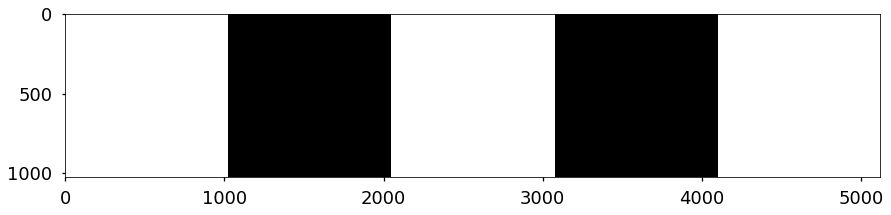

In [14]:
t, s, c, h, w = im_all.shape
im_out = np.zeros((t,3,h,5*w), dtype=np.float32)

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, 5*w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = np.ones([h, w])
red_array[:,:,1] = np.ones([h, w]) * 0
red_array[:,:,2] = np.ones([h, w]) * 0.
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = np.ones([h, w]) * 0
cyan_array[:,:,1] = np.ones([h, w]) 
cyan_array[:,:,2] = np.ones([h, w])
i=70
# Plot cell densities
min_v = [10e3, 100, 100]
max_v = [30e3, 500, 500]
plt.figure(figsize=(15,3))
# Plot cell densities
frame = np.zeros([h, 5*w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    for p, p_i in enumerate([5,4,3]):
        d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#         d_arr[d_arr > 1 ] = 1
#         d_arr[d_arr < 0 ] = 0
        frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
plt.imshow(frame)


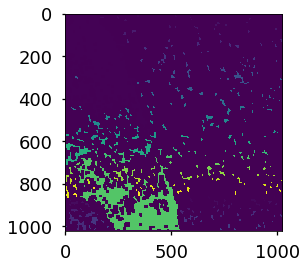

In [8]:
with skimage.external.tifffile.TiffFile('mask_images/mask_44_13.tif') as img:
    im_mask = img.asarray(memmap=True)
_ = plt.imshow(im_mask)

In [ ]:
#
#  Use masks to track fluorescence of microcolonies
#

import matplotlib.animation as anm
from IPython.display import HTML

def par_worker(im_arr, t_df, fn_out):
    img_temp = "mask_images/mask_{:02d}_{:1d}.tif"
    column_names = ('frame','time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    t_df_piv = t_df.pivot('frame', 'pos', 'time')
    for t_i in range(0,t,1):
        i_frame = t_df.index[t_i]
        for s_i in range(s):
            ct = t_df_piv.loc[i_frame, s_i]
#             im_labeled, num = label_image_2(im_arr[t_i, s_i, 1:2,:,:].sum(axis=0))
            rfps, gfps, sizes, num, gfp_bg, rfp_bg, im_labeled = get_fluors_2(im_arr[t_i,s_i,1,:,:], 
                                                                              im_arr[t_i,s_i,2,:,:])
            img_fn = img_temp.format(i_frame, s_i)
            skimage.io.imsave(img_fn, im_labeled.astype(np.uint8))
#             for col_i in range(num):
#                 df_dict = dict(zip(column_names, [[i_frame],[ct], [s_i], [col_i], [gfps[col_i]], [rfps[col_i]], [sizes[col_i]], [gfp_bg], [rfp_bg]]))
#                 df = df.append(pd.DataFrame(df_dict), ignore_index=True)
#     df.to_csv(fn_out)
    print("wrote ", fn_out)

fn_temp = "processed_part_masktry_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_df.loc[i::4,:], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint

In [15]:
#
# Simply take means of the full field of view
#

def par_worker(im_arr, t_vec, fn_out):
    column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
    df = pd.DataFrame(columns=column_names)
    t, s, _, h, w = im_arr.shape
    for t_i in range(0,t,1):
        for s_i in range(s):
            ct = t_vec[t_i]
            df_dict = dict(zip(column_names, [[ct], [s_i], [im_arr[t_i,s_i,2,:,:].mean()], [im_arr[t_i,s_i,1,:,:].mean()]]))
            df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    df.to_csv(fn_out)
    print("wrote ", fn_out)

# t_df = pd.read_csv('time.csv', index_col=None)
t_piv = t_df.pivot('frame', 'pos', 'time')
fn_temp = "full_image_part_2_{}.csv"
fn_outs = [fn_temp.format(i) for i in range(4)]

jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(im_all[i::4,:,:,:,:], 
                                t_piv.values[i::4,0], fn_outs[i]))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")

wrote  full_image_part_2_2.csv
wrote  full_image_part_2_3.csv
wrote  full_image_part_2_0.csv
wrote  full_image_part_2_1.csv
Done!


In [98]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn, dtype=np.float), ignore_index=True)

df.head(10)

Unnamed: 0  col_size  colony  frame    mscarlet  mscarlet_bg  pos  \
0         0.0     309.0     0.0    0.0  490.870550   503.680365  0.0   
1         1.0     455.0     1.0    0.0  496.424176   503.680365  0.0   
2         2.0   37444.0     2.0    0.0  518.279965   503.680365  0.0   
3         3.0      26.0     3.0    0.0  489.115385   503.680365  0.0   
4         4.0      11.0     4.0    0.0  498.727273   503.680365  0.0   
5         5.0      32.0     5.0    0.0  495.218750   503.680365  0.0   
6         6.0      19.0     6.0    0.0  487.631579   503.680365  0.0   
7         7.0      56.0     7.0    0.0  492.464286   503.680365  0.0   
8         8.0      15.0     8.0    0.0  504.733333   503.680365  0.0   
9         9.0      79.0     9.0    0.0  502.354430   503.680365  0.0   

        sfcfp    sfcfp_bg          time  
0  691.915858  717.575823  1.527899e+09  
1  696.118681  717.575823  1.527899e+09  
2  726.601618  717.575823  1.527899e+09  
3  696.192308  717.575823  1.527899e+09  
4  698.545455  717.575823  1.527899e+09  
5  703.312500  717.575823  1.527899e+09  
6  685.947368  717.575823  1.527899e+09  
7  696.946429  717.575823  1.527899e+09  
8  709.066667  717.575823  1.527899e+09  
9  702.088608  717.575823  1.527899e+09

In [107]:
temp = 'processed_part_masktry_{}.csv'
column_names = ('time', 'pos', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
df = pd.DataFrame(columns=column_names)
for fn in [temp.format(i) for i in range(4)]:
    df = df.append(pd.read_csv(fn), ignore_index=True)
t_df_piv = t_df.pivot('frame', 'pos', 'time')
for i in np.arange(df.shape[0]):
    i_frame, i_pos = df.loc[i, ["frame","pos"]]
    df.loc[i,'time'] = t_df_piv.loc[np.int(i_frame), i_pos]
df.to_csv('{}_masktry_df_2.csv'.format(nb_prefix))

6.54677459103961
11.2875
False
0.0


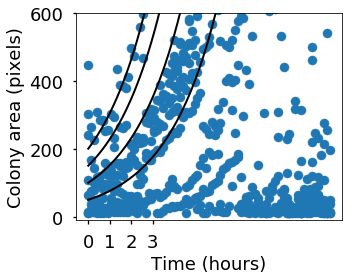

In [108]:
# df = pd.read_csv('{}_masktry_df.csv'.format(nb_prefix))
fig, ax = plt.subplots(1,1,figsize=(5,4))
t_min = df.time.min()
ind = (df.pos == 4) & (df.colony>1) & (df.colony<10) # & (np.mod(df.colony,  5)==0 )
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.col_size,
           alpha=1, cmap='viridis')
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
for i in np.arange(50,210,50):
    ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
ax.set_ylim([-1e1,200])
ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
ax.set_xticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


6.54677459103961
11.2875
False
0.0


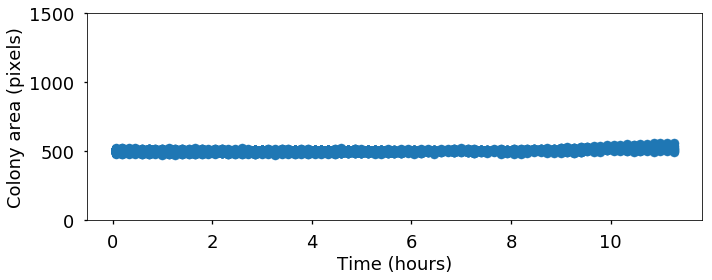

In [151]:

fig, ax = plt.subplots(1,1,figsize=(10,4))
t_min = df.time.min()
ind = np.isclose(df.pos.astype(np.int), 21)
df_tmp = df.loc[ind,:]
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.mscarlet,'r.')
# ax.plot((df_tmp.time - t_min)/3600, df_tmp.sfcfp,'c.')
ax.scatter(x=(df_tmp.time - t_min)/3600, 
           y=df_tmp.mscarlet,#/ 
#            c=df_tmp.mscarlet,
           alpha=1)#, cmap='viridis')
ax.set_ylim([0,1.5e3])
new_t_vec = np.sort(np.unique(df_tmp.time - t_min))
r_c = (7e-3)/60
# for i in np.arange(50,210,50):
#     ax.plot(new_t_vec/3600, i*np.exp(new_t_vec*r_c),'k-')
# ax.set_facecolor('gray')
# ax.set_ylim([600,800])

# ax.set_yticks(np.arange(0,601,200))
ax.set_ylabel('Colony area (pixels)')
ax.set_xlabel('Time (hours)')
# ax.set_xticks(np.arange(4,8,1))
# ax.set_xlim([0,800])
fig.tight_layout()
# fig.savefig("microscope_cellgrowth.png", dpi=150, transparent=True)
# fig.savefig("microscope_cellgrowth.pdf")
# fig, ax = plt.subplots(1,1,figsize=(9,9))
# # ind = (df.time < (6*60*60 + t_min)) & (df.pos == 3)
# # df_tmp = df.loc[ind,:]
to_full_screen = np.log((1024**2)/67057)/r_c
print(to_full_screen / 3600)
print((df.time.max() - t_min)/3600)
print(df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())
print((df.loc[(df.time == t_min)&(df.pos == 4), 'col_size'].sum())/(1024**2))
# ax.scatter(x=df_tmp.mscarlet, 
#            y=df_tmp.sfcfp,
#            c=df_tmp.time,alpha=0.3, cmap='viridis')
# ax.set_facecolor('gray')
# (df_tmp.time[df_tmp.sfcfp > 200].min() - df_tmp.time[df_tmp.mscarlet > 200].min())


In [118]:
df.pos.astype(np.int)

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
252139    31
252140    31
252141    31
252142    31
252143    31
252144    31
252145    31
252146    31
252147    31
252148    31
252149    31
252150    31
252151    31
252152    31
252153    31
252154    31
252155    31
252156    31
252157    31
252158    31
252159    31
252160    31
252161    31
252162    31
252163    31
252164    31
252165    31
252166    31
252167    31
252168    31
Name: pos, Length: 252169, dtype: int64

In [17]:
from scipy import optimize as opt
def f_fun(p, t):
    c0,c1,c2 = p
    return c0 + c1 * (t)**c2

def f_res(p, t, fit_x):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
    if c2 < 0:
        return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)

def fit_wrapper(t_vec, x_vec):
    est_slope = (x_vec[-1] - x_vec[0]) / (t_vec[-1] - t_vec[0])
    est_y_int = x_vec[0] - t_vec[0]*est_slope
    p_0 = np.array([est_y_int, est_slope, 1])
    fit_out = opt.minimize(f_res, p_0, args=(t_vec, x_vec))
    fit_p = fit_out.x
    return fit_p

[ 4.39972222  6.93305556  7.46638889  7.46638889  6.26638889  5.46638889
  5.86638889  6.79972222 10.13305556 11.86638889 11.86638889 11.86638889
 11.86638889 11.86638889 11.86638889]
[3.55488638e+00 3.71786514e-04 4.13229189e+00]
[ 5.86638889  8.79972222  9.86638889  6.53305556  6.66638889  5.19972222
  3.33305556  2.93305556  4.13305556 11.86638889 11.86638889 11.86638889
 11.86638889 11.86638889 11.86638889 11.86638889]
[4.70402879e+00 3.70595007e-07 6.91409133e+00]


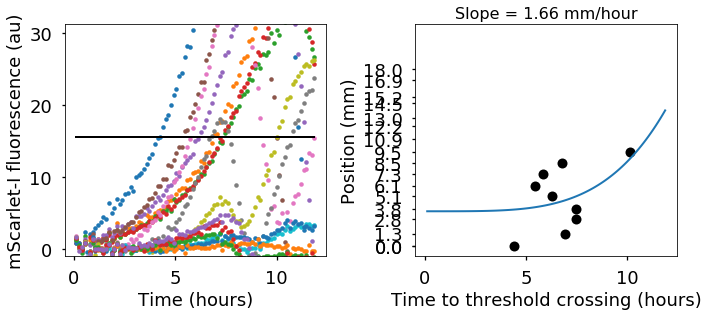

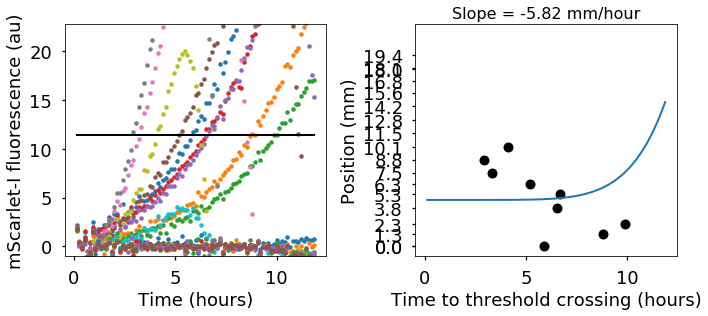

In [48]:
# temp = 'full_image_part_2_{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# df.pos = df.pos.astype(np.float)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
# df.to_csv('full_image.csv', index=False)
df = pd.read_csv('full_image.csv')
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels, channel, chan_lab):
    fig, axs = plt.subplots(1,2, figsize=(10,4.5))
    df = df.sort_values('time')
    n = len(pos_list)
#     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
    tim_inds = ((df.time - t_min)/3600) > -1
    df_bg = df.loc[(df.pos==0),channel]
    bg = df_bg.values
    pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
    df_sub = df.loc[pos_inds & tim_inds,:]
    df_piv = df_sub.pivot('pos', 'time', channel)
    arr = df_piv.values - bg
    diff_mat = np.diff(arr, axis=1)
    thresh = skimage.filters.threshold_li(diff_mat)
    arr_thresh = diff_mat > thresh
    t_vec = df_piv.columns.values[1:]
    t_vec_corr = (t_vec - t_min)/3600
    t_cross = np.zeros(n) * np.nan
    for i in np.arange(n):
        t_thresh = t_vec[arr_thresh[i,:]]
        if len(t_thresh) > 0:
            t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
    x_vec = cor_pos_df.loc[pos_list,['x', 'y']]-cor_pos_df.loc[pos_list[0],['x', 'y']]
    x_vec = np.power(np.sum(np.power(x_vec,2).values,axis=1),0.5)/1000
    cross_vec = (t_cross - t_min)/3600
    axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
    n_cross = np.sum(1 - np.isnan(t_cross))
    if n_cross > 1:
        keep_inds = np.isnan(cross_vec)
        cross_vec[keep_inds] = t_vec_corr.max()
        interp_t = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
        fit_p = fit_wrapper(cross_vec, x_vec)
        interp_x = f_fun(fit_p, interp_t)
        axs[1].plot(interp_t, interp_x, '-')
        print(cross_vec)
        print(fit_p)
    if np.isnan(t_cross).sum() < (len(t_cross)-2) : 
        nan_inds = np.isnan(t_cross)
        cv = cross_vec[nan_inds == False]
        xv = x_vec[nan_inds == False]
        slope = (xv[-1] - xv[0]) / (cv[-1] - cv[0])
#         print("cv",cv)
#         print("slope",slope)
        axs[1].set_title("Slope = {:0.2f} mm/hour".format(slope), fontsize=16)
    axs[0].plot((t_vec - t_min) / 3600, diff_mat.T, '.')
    axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
    axs[0].set_ylim([-1,2*thresh])
#     axs[0].set_yticks(np.arange(0,31,10))
    axs[0].set_ylabel(chan_lab)
    axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,11,2))
#     axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
#                   loc=2, frameon=True)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
    axs[1].set_ylim([-1, 5*4.5])
    x_tix = np.array([0] + list(x_vec) + [18])
    axs[1].set_yticks(x_tix)
    axs[1].set_yticklabels(np.round(x_tix,1))
#     axs[1].set_xticks(np.arange(1,11,2))
    axs[1].set_xlabel("Time to threshold crossing (hours)")
    axs[1].set_ylabel("Position (mm)")
    plt.tight_layout()

# labels = 3*["Signal source", "Near", "Far"]
labels = np.arange(n_p)
plot_positions(df, np.arange(2,17), "Passive transmission", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
plt.savefig('pad2_mscarlet.pdf')
plt.savefig('pad2_mscarlet.png', dpi=150, transparent=True)
plot_positions(df, np.arange(17,n_p), "Active transmission", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
plt.savefig('pad3_mscarlet.pdf')
plt.savefig('pad3_mscarlet.png', dpi=150, transparent=True)
# plot_positions(df, [26], "Senders, receivers", labels, 'mscarlet', 'mScarlet-I fluorescence (au)')
# plt.savefig('pad3_mscarlet.pdf')
# plt.savefig('pad3_mscarlet.png', dpi=150, transparent=True)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.
/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars


[0.13305556 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556
 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556
 0.13305556 0.13305556 0.13305556]
[-inf  inf   1.]
[0.13305556 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556
 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556 0.13305556
 0.13305556 0.13305556 0.13305556 0.13305556]
[-inf  inf   1.]


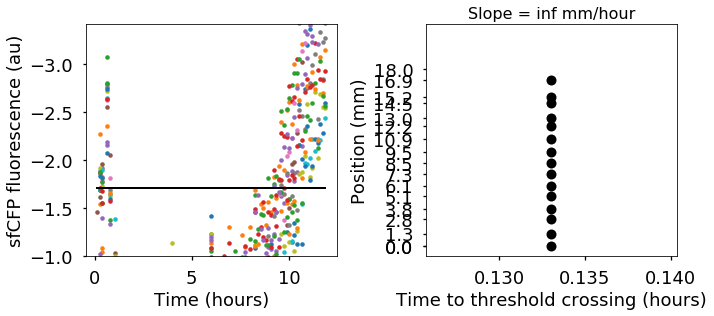

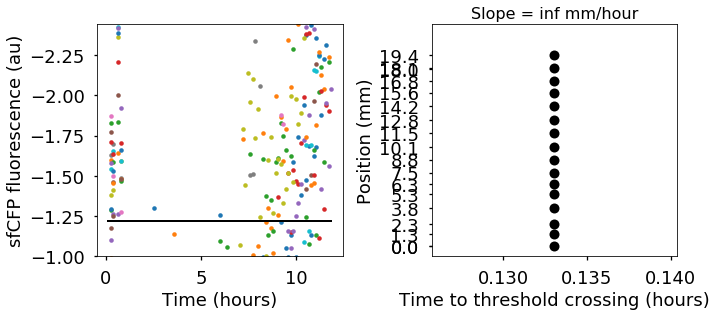

In [49]:
# temp = 'full_image_part{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn, index_col=0), ignore_index=True)
    
# t_min = df.time.min()

# def plot_positions(df, pos_list, title, labels, channel, chan_lab):
#     fig, axs = plt.subplots(1,2, figsize=(10,4.5))
#     df = df.sort_values('time')
#     n = len(pos_list)
# #     for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
#     tim_inds = ((df.time - t_min)/3600) < 10
#     df_bg = df.loc[tim_inds&(df.pos==1),channel]
#     bg = np.tile(df_bg.values.T, (n, 1))
#     pos_inds = np.sum([df.pos == xx for xx in pos_list],axis=0) > 0
#     df_sub = df.loc[pos_inds & tim_inds,:]
#     df_piv = df_sub.pivot('pos', 'time', channel)
#     t_vec = df_piv.columns.values
#     t_vec_corr = (t_vec - t_min)/3600
#     arr = df_piv.values - bg
#     thresh = 10
#     arr_thresh = arr > thresh
#     t_cross = np.zeros(n) * np.nan
#     for i in np.arange(n):
#         t_thresh = t_vec[arr_thresh[i,:]]
#         if len(t_thresh) > 0:
#             t_cross[i] = t_thresh.min()
#     x_vec = positions_list[pos_list.astype(int),:]
#     x_vec = np.array([np.sqrt(np.power(xx - x_vec[0,:],2).sum())/1e3 for xx in x_vec])
#     cross_vec = (t_cross - t_min)/3600
#     axs[1].plot(cross_vec, x_vec, 'ko', ms=10)
#     n_cross = np.sum(1 - np.isnan(t_cross))
#     if n_cross > 1:
#         interp_x = np.linspace(t_vec_corr[0], t_vec_corr[-1],100)
#         f_interp = scp.interpolate.interp1d(cross_vec[:n_cross], x_vec[:n_cross], 
#                                             kind='linear', fill_value='extrapolate')
#         interp_y = f_interp(interp_x)
#         axs[1].plot(interp_x, interp_y, '-')
#     if np.isnan(t_cross).sum() < 2 : 
#         nan_inds = np.isnan(t_cross)
#         cv = cross_vec[(1-nan_inds)>0]
#         xv = x_vec[(1-nan_inds)>0]
#         slope = np.diff(xv) / np.diff(cv)
# #         print(slope)
#         axs[1].text(0.6,11,"Slope = {:0.2f} mm/hour".format(slope[0]), fontsize=16)
#     axs[1].set_xlim([t_vec_corr[0], t_vec_corr[-1]])
#     axs[1].set_ylim([-1, 4*4.5])
#     axs[0].plot((t_vec - t_min) / 3600, arr.T, '.')
#     axs[0].plot([t_vec_corr[0], t_vec_corr[-1]], 2*[thresh], 'k-')
#     axs[0].set_ylim([-1,20])
#     axs[0].set_yticks(np.arange(0,31,10))
#     axs[1].set_yticks(np.arange(0,17,5))
#     axs[0].set_ylabel(chan_lab)
#     axs[0].set_xlabel("Time (hours)")
#     axs[0].set_xticks(np.arange(1,7,2))
#     axs[0].legend(labels=['Proximal', 'Intermediate', 'Distal','Threshold'], 
#                   loc=2, frameon=True)
#     axs[1].set_xticks(np.arange(1,7,2))
#     axs[1].set_xlabel("Time to threshold crossing (hours)")
#     axs[1].set_ylabel("Position (mm)")
#     plt.tight_layout()

# labels = 3*["Signal source", "Near", "Far"]
# labels = np.arange(16)
plot_positions(df, np.arange(2,17), "Passive transmission", labels, 'sfcfp', 'sfCFP fluorescence (au)')
plt.savefig('pad2_sfcfp.pdf')
plt.savefig('pad2_sfcfp.png', dpi=150, transparent=True)
plot_positions(df, np.arange(17,n_p), "Active Transmission", labels, 'sfcfp', 'sfCFP fluorescence (au)')
plt.savefig('pad3_sfcfp.pdf')
plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, np.arange(13,29), "Senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad2_sfcfp.pdf')
# plt.savefig('pad2_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, np.arange(29,32), "Senders, pulsers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad3_sfcfp.pdf')
# plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)
# plot_positions(df, [26], "Senders, receivers", labels, 'sfcfp', 'sfCFP fluorescence (au)')
# plt.savefig('pad3_sfcfp.pdf')
# plt.savefig('pad3_sfcfp.png', dpi=150, transparent=True)


In [21]:
# temp = 'full_image_part{}.csv'
# column_names = ('time', 'pos', 'sfcfp', 'mscarlet')
# df = pd.DataFrame(columns=column_names)
# for fn in [temp.format(i) for i in range(4)]:
#     df = df.append(pd.read_csv(fn), ignore_index=True)
    
t_min = df.time.min()

def plot_positions(df, pos_list, title, labels):
    fig, axs = plt.subplots(1,2, figsize=(7,4))
    for c_i, channel in enumerate(["mscarlet", "sfcfp"]):
        bg = df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),channel]
        arr = np.zeros((3,bg.shape[0]))
        for i in pos_list:
            indx = (df.pos == i) & (df.time < (t_min+7*3600))
            x = (df.time[indx].values - t_min)/3600
            order_inds = np.argsort(x)
            y = df.loc[indx,channel].values - bg.values
            arr[np.mod(i,3), :] = y[order_inds]
        axs[c_i].imshow(arr, vmin=0, vmax=10)
        axs[c_i].set_title(title)
        axs[c_i].set_aspect(4)
        axs[c_i].set_xlabel("Time (hours)")
        axs[c_i].set_ylabel("Position")
        axs[c_i].set_yticks(np.arange(3))
        axs[c_i].set_yticklabels([""])
#         axs[c_i].set_ylim([-10,50])
#         axs[c_i].legend(loc=2)
    plt.tight_layout()

labels = 3*["Signal source", "Near", "Far"]
plot_positions(df, np.arange(11), "Inactive senders, pulsers", labels)
plt.savefig('pad1.pdf')
plot_positions(df, np.arange(11,26), "Senders, pulsers", labels)
plt.savefig('pad2.pdf')
plot_positions(df, [26], "Senders, receivers", labels)
plt.savefig('pad3.pdf')
print(df.loc[(df.pos==1)& (df.time < (t_min+7*3600)),'mscarlet'].shape)

FileNotFoundError: File b'full_image_part0.csv' does not exist

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(positions_list[:,0]/1e3,positions_list[:,1]/1e3,'.')
plt.xticks(positions_list[:,0]/1e3, rotation = -45)

In [ ]:
np.sqrt(np.power(positions_list[3,:] - positions_list[4,:], 2).sum())/1000

In [ ]:
# plt.imshow(im_all[:,4,2,:,:].mean(axis=2), aspect=10)#, vmin=100, vmax=500)
# plt.colorbar()
mean_slice = im_all[:,4,2,:,:].mean(axis=2)
thresh = skimage.filters.threshold_otsu(mean_slice)
_ = plt.plot(im_all[:,4,2,:,:].mean(axis=2))#, aspect=10)#, vmin=100, vmax=500)
plt.plot([0,100], [thresh, thresh])

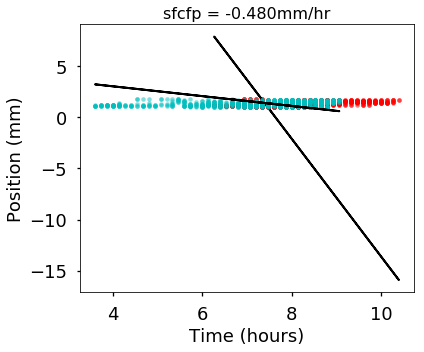

In [149]:
import scipy.optimize as opt
tvec = np.sort(np.unique(df.time.values)) / 3600.0
tvec = tvec - tvec.min()
def proc_pos_thresh(arr, tvec, c='r'):
    _, w = arr.shape
    arr = arr
    thresh = skimage.filters.threshold_otsu(arr) # arr[-1,:].min() #+ 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()

    offset = np.sqrt(np.sum(np.power(cor_pos_df.loc[13,['x', 'y']]-cor_pos_df.loc[14,['x', 'y']],2)))
    xvec = np.arange(w)*(0.768/1024) + (offset/1e3)
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    arr_maxes = arr.mean(axis=0)

    def f_fun(p, t=fit_crossings):
        c0,c1 = p
        return c0 + c1 * (t)

    def f_res(p, t=fit_crossings):
        c0,c1 = p
        if c1 < 0:
            return np.inf
    #     if c2 < 0:
    #         return np.inf
        res = fit_x - f_fun(p, t)
        return np.sum(res*res)

    est_slope = (fit_x[-1] - fit_x[0]) / (fit_crossings[-1] - fit_crossings[0])
    est_y_int = fit_x[0] - fit_crossings[0]*est_slope
    fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope]))
    fit_p = fit_out.x
    plt.plot(fit_crossings, fit_x, c, alpha=0.5)
    plt.plot(fit_crossings, f_fun(fit_p),'k')
    plt.xlabel("Time (hours)")
    plt.ylabel("Position (mm)")
    return fit_p

plt.figure(figsize=(6,5))
# tslice = slice(45, 65)
fit_r = proc_pos_thresh(im_all[:,14,1,:,:].mean(axis=1), tvec[:], 'r.')
plt.title("mscarlet = {:.3f}mm/hr".format(fit_r[1]), fontsize=16)

# plt.figure(figsize=(6,5))
fit_c  = proc_pos_thresh(im_all[:,14,2,:,:].mean(axis=1)+0.00, tvec[:], 'c.')
plt.title("sfcfp = {:.3f}mm/hr".format(fit_c[1]), fontsize=16)
plt.tight_layout()
plt.savefig('within_pos_velocity.pdf')
plt.savefig('within_pos_velocity.png', dpi=150, transparent=True)
# plt.ylim([-0.02,0.8])
# plt.xlim([5, 8])


# widths = above_thresh.sum(axis=1)
# mean_width = np.sum(widths[:-1] * np.diff(tvec)) / (tvec[-1] - tvec[0])
# fit_df.loc[i,"width"] = mean_width * (4.5/scale)
# arr_maxes = arr.max(axis=0)
# peak_vec = np.array([tvec[arr[:,i] == arr_maxes[i]][0] for i in np.arange(len(arr_maxes))])
# fit_df.loc[i, "pulse"] = np.float((len(tvec) * 0.05) > np.sum(np.diff(peak_vec) < 1))
# if len(fit_x)>0:
#     fit_df.loc[i, "mean_v"] = fit_x.max()/fit_crossings.max()
#     fit_df.loc[i, "amp"] = arr_maxes.mean()
# else:
#     fit_df.loc[i, "mean_v"] = 0
#     fit_df.loc[i, "amp"] = 0

In [ ]:
tslice = slice(45, 65)
arr = im_all[tslice,4,1,:,-10:10:-1].mean(axis=1)
tvec_tmp = tvec[tslice]
thresh = skimage.filters.threshold_li(arr)
_ = plt.plot(tvec_tmp,  arr)
_ = plt.plot([tvec_tmp[0], tvec_tmp[-1]], [thresh,thresh])

In [ ]:
fig = plt.figure(figsize=(5,4))
bg_ind = df.pos == 1
bg_msc = df.loc[bg_ind, 'mscarlet'].values
bg_sfc = df.loc[bg_ind, 'sfcfp'].values
tmin = df.time.min()
for i in np.arange(3,9):
    ind = df.pos == i
    df_sub = df.loc[ind, :]
    tv = df_sub.time - tmin
    plt.plot(tv, df_sub.mscarlet.values - bg_msc, 'r.', lw=8)
    plt.plot(tv, df_sub.sfcfp.values - bg_sfc, 'c.', lw=8)
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean fluor\n(au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

In [ ]:

def write_movie(im_arr, skip=1, maxframe=100):
    plt.close('all')
    
    t, s, c, h, w = im_arr.shape
    im_out = np.zeros((t,3,h,5*w))
    
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, 5*w, 3])
    gray_array = np.ones([h, w, 3])
    red_array = np.zeros([h, w, 3])
    red_array[:,:,0] = 1#np.ones([h, w])
    red_array[:,:,1] = 0#np.ones([h, w]) * 0.0
    red_array[:,:,2] = 0#np.ones([h, w]) * 0.0
    cyan_array = np.zeros([h, w, 3])
    cyan_array[:,:,0] = 0#np.ones([h, w]) * 0.0
    cyan_array[:,:,1] = 1#np.ones([h, w]) 
    cyan_array[:,:,2] = 1#np.ones([h, w])
    fig, axs = plt.subplots(3,1, dpi=175, figsize=(5,4))
    im_list = [0,0,0]
    
    # Plot cell densities
    ax = axs[0]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Inactive Senders, active propagation')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[1]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, active propagation')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[2]
    im = ax.imshow(blank_array, animated=True, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Active Senders, passive propagation')
    im_list[2] = im
#     fig.tight_layout()
    def animate(i):
        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        
        # Plot cell densities
        ax = axs[0]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([2,1,0]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[0].set_array(frame)

        min_v = [5e3,  100, 100]
        max_v = [27e3, 5e2, 5e2]
        # Plot nutrient densities
        ax = axs[1]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([5,4,3]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[1].set_array(frame)

        
        min_v = [15e3, 100, 100]
        max_v = [30e3, 5e2, 5e2]
        # Plot synthase densities
        ax = axs[2]
        frame = np.zeros([h, 5*w, 3])
        for c, c_array in enumerate([gray_array, red_array, cyan_array]):
            for p, p_i in enumerate([8,7,6]):
                d_arr = (im_all[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
                frame[:,(2*w*p):(2*w*(1+p)-w),:] += c_array * np.stack(3*[d_arr], axis=2)
        frame[frame > 1 ] = 1
        frame[frame < 0 ] = 0
        im_list[2].set_array(frame)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    writer = anm.ImageMagickFileWriter(20)
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=np.arange(0, maxframe, skip))

    anim.save('animation_pulse.gif', writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())

# anim = write_movie(im_all, skip=1, maxframe=80)
# HTML(anim.to_html5_video())

In [ ]:
fig = plt.figure(figsize=(5,4))
for i in np.arange(3,9):
    plt.plot(tvec, im_all[:,i,1,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,1,:,:].mean(axis=1).mean(axis=1)
             , 'r', lw=8)
    plt.plot(tvec,im_all[:,i,2,:,:].mean(axis=1).mean(axis=1) - im_all[:,0,2,:,:].mean(axis=1).mean(axis=1)
             , 'c')
# plt.ylim([100,180])

plt.xlabel('Time (hours)')
plt.ylabel('Mean mScarlet-I\nfluoresecence (au/pixel)')
fig.tight_layout()
# fig.savefig("exp_constitutive.pdf")
# fig.savefig("exp_constitutive.png", dpi=150, transparent=True)

In [ ]:
fig = plt.figure(figsize=(5,4))
imax = 20
bg_inds = df.pos == 5
t_min = df.time.min()
for i in np.arange(3,4):
    inds = df.pos == i 
    time_vec = (df.loc[inds, 'time'].values - t_min) / 3600
    plt.plot(time_vec, df.loc[inds, 'mscarlet'].values - df.loc[bg_inds, 'mscarlet'].values, 'r.',ms=16)
    plt.plot(time_vec, df.loc[inds, 'sfcfp'].values    - df.loc[bg_inds, 'sfcfp'].values, 'c.',ms=16)

df_sub = df.loc[(df.pos == 4 ) | (df.pos == 3 ), ['sfcfp', 'mscarlet', 'time']]
under_thresh = df_sub.loc[:,['sfcfp', 'mscarlet']] < 1
t1 = df_sub.loc[under_thresh['mscarlet'],'time'].max()

plt.xlim([-0.1,2])
plt.xticks([0, 0.5, 1.1, 2])
plt.ylim([-0.15,3])
plt.xlabel('Time (hours)')
plt.ylabel('Mean sfCFP\nfluorescence (au/pixel)')
plt.yticks(np.arange(0,4,1))
fig.tight_layout()
fig.savefig("exp_sender_receiver_delay.png", dpi=150, transparent=True)
fig.savefig("exp_sender_receiver_delay.pdf")
# plt.ylim([100,180])

IndexError: too many indices for array

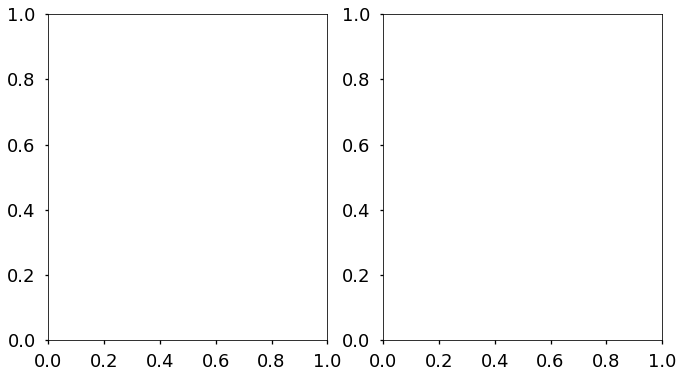

In [34]:
# Plot each column of each image at each position

import scipy.optimize as opt
# tvec = np.sort(np.unique(df.time.values)) / 3600.0
# tvec = tvec - tvec.min()
t_min = t_df.time.min()
def thresh_by_positions(pad, chan, position_list, c='r', axs=None):
    pos_bg = 12
    n_t, n_p, n_c, h, w = im_all.shape
#     position_list = np.array([np.int(xx) for xx in cor_pos_df.loc[cor_pos_df.pad == pad, "pos"].values])
    n_pos = len(position_list)
    pos_0 = np.min(position_list)
    for p_i in position_list:
        # Determine threshold crossing times for each column of this field of view
        fluo_cols = im_all[:,p_i,chan,:,:].sum(axis=1)
        col_cols = (im_masks[:,p_i,:,:]>0).sum(axis=1)
        if np.sum(col_cols) < 5e3:
            continue
        frame_arr = fluo_cols / col_cols
        frame_arr[np.isinf(frame_arr)] = 0
        thresh = skimage.filters.threshold_li(frame_arr)
        ind_arr = np.tile(np.arange(85), (1024,1)).T
        ind_arr[frame_arr < thresh] = 85 # Set no-crossings to max timepoint

        # Calculate x positions of each column
        offset = np.sqrt(np.sum(np.power(prox_df.loc[pad,['X', 'Y']].values-cor_pos_df.loc[p_i,['x', 'y']].values,2)))
        xvec = np.arange(w)*(0.768/1024) + (offset/1e3)
        
        # Convert crossing indices to x, t values
        crossings = ind_arr.min(axis=0)
        tvec = t_df.loc[t_df.pos==p_i,"time"].values - t_min
        tvec.sort()
        fit_t = np.array([tvec[xx] for xx in crossings if xx < 85])
        fit_x = np.array([xvec[xx] for xx in np.arange(w) if crossings[xx] < 85])
        
        def f_fun(p, t=fit_t):
            c0,c1 = p
            return c0 + c1 * (t)

        def f_res(p, t=fit_t):
            c0,c1 = p
            if c1 < 0:
                return np.inf
        #     if c2 < 0:
        #         return np.inf
            res = fit_x - f_fun(p, t)
            return np.sum(res*res)

        est_slope = (fit_x[-1] - fit_x[0]) / (fit_t[-1] - fit_t[0])
        est_y_int = fit_x[0] - fit_t[0]*est_slope
        fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope]))
        fit_p = fit_out.x
        axs[0].plot(fit_x.mean(), fit_p[1]*3600, c, alpha=0.6,ms=20)
        axs[1].plot(fit_t/3600, fit_x, c, alpha=0.5)
#         axs[1].plot(fit_t, f_fun(fit_p), 'k-', alpha=0.5)
        
#     plt.xlabel("Time (hours)")
#     plt.ylabel("Position (mm)")
    return
#     return fit_p

# plt.figure(figsize=(6,5))
fig, axs = plt.subplots(1, 2, figsize=(11,6))
tslice = slice(45, 65)
position_list = np.array([np.int(xx) for xx in cor_pos_df.loc[cor_pos_df.pad == 2, "pos"].values[:1]])
# fit_r = thresh_by_positions(2, 1, position_list, 'r.', axs)
fit_r = thresh_by_positions(2, 1, position_list, 'r.', axs)
fit_r = thresh_by_positions(2, 2, position_list, 'c.', axs)
axs[0].set_ylabel('Velocity (mm/hour)')
axs[0].set_xlabel('Position (mm)')
axs[0].set_title('Estimated velocity at\npad positions')
axs[1].set_ylabel('Position (mm)')
axs[1].set_xlabel('Time (hour)')
axs[1].set_xlim([-0.5,5])
axs[1].set_title('Threshold crossing events')
fig.tight_layout()


In [248]:
x_vec, chan_arr = fit_r
thresh = skimage.filters.threshold_yen(chan_arr)
plt.plot(fit_r[0],'.')

TypeError: 'NoneType' object is not iterable

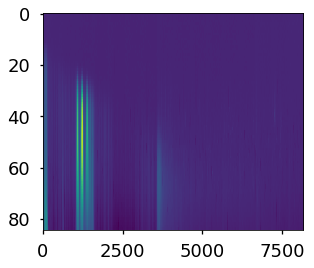

In [58]:
_ = plt.imshow(fit_r[1], aspect=100)

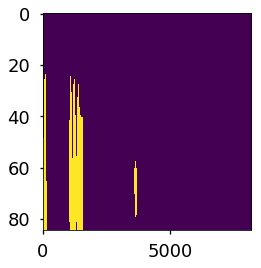

In [89]:
thresh = skimage.filters.threshold_otsu(fit_r[1])
above_thresh = fit_r[1] > thresh
_ = plt.imshow(above_thresh, aspect=100)

In [69]:
df_masked = pd.read_csv('{}_masktry_df_2.csv'.format(nb_prefix), index_col=0).iloc[:,1:]

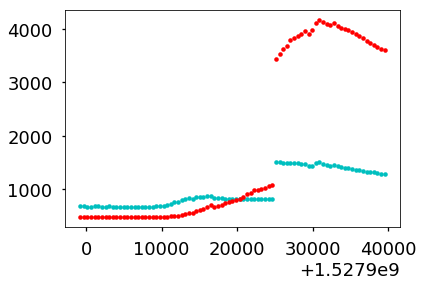

In [84]:
df_tmp = df_masked.loc[(df_masked.colony == 0) & (df_masked.pos == 15),:]
plt.plot(df_tmp.time, df_tmp.sfcfp,'c.')
plt.plot(df_tmp.time, df_tmp.mscarlet,'r.')

In [78]:
df_masked.head()

col_size  colony  frame    mscarlet  mscarlet_bg  pos       sfcfp  \
0       309       0    0.0  490.870550   503.680365    0  691.915858   
1       455       1    0.0  496.424176   503.680365    0  696.118681   
2     37444       2    0.0  518.279965   503.680365    0  726.601618   
3        26       3    0.0  489.115385   503.680365    0  696.192308   
4        11       4    0.0  498.727273   503.680365    0  698.545455   

     sfcfp_bg          time  
0  717.575823  1.527899e+09  
1  717.575823  1.527899e+09  
2  717.575823  1.527899e+09  
3  717.575823  1.527899e+09  
4  717.575823  1.527899e+09

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


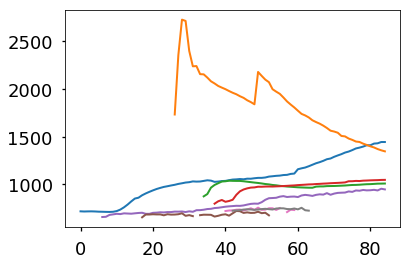

In [143]:
chan = 2
for pos in np.arange(13,29,2):
    # bg_size = np.sum(np.sum(im_masks[:,pos,:,:]==0,axis=1),axis=1)
    mask = im_masks[:,pos,:,:] > 0
    bg_mask = im_masks[:,pos,:,:] == 0
    sfcfp = im_all[:,pos,chan,:,:] * mask
    sfcfp_vec = sfcfp.sum(axis=1).sum(axis=1)
    mask_vec = mask.sum(axis=1).sum(axis=1)
    bg = im_all[:,pos,chan,:,:] * bg_mask
    bg_vec = bg.mean(axis=1).mean(axis=1)# + im_all[:,12,2,:,:].mean(axis=1).mean(axis=1)
#     bg_vec = im_all[:,12,chan,:,:].mean(axis=1).mean(axis=1)
    _ = plt.plot((sfcfp_vec-bg_vec) / mask_vec)


/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


IndexError: too many indices for array

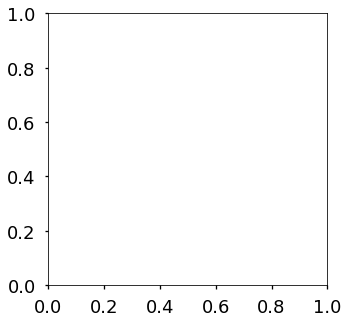

In [58]:
pos = 14
fig, ax = plt.subplots(1,1,figsize=(5,5))
# for pos in np.arange(13,29):
fluo_cols = im_all[:,13:19,2,:,:].sum(axis=2)
col_cols = (im_masks[:,13:19,:,:]>0).sum(axis=2)
n_t, n_p, w = fluo_cols.shape
frame_arr = fluo_cols / col_cols
frame_arr[np.isinf(frame_arr)] = 0
thresh = skimage.filters.threshold_otsu(frame_arr)
ind_arr = np.tile(np.arange(85), (w*n_p,1)).T

xvec = np.linspace(0,786,1024)
ind_arr[frame_arr < thresh] = 85
crossings = ind_arr.min(axis=0)
tvec = t_df.loc[t_df.pos==19,"time"].values.argsort()
t_crossings = np.array([tvec[xx] for xx in crossings if xx < 85])
x_crossings = np.array([xvec[xx] for xx in np.arange(1024) if crossings[xx] < 85])

print(thresh)
plt.figure(figsize=(10,10))
# frame_arr[frame_arr < thresh] = 0
ax.plot(frame_arr.mean(axis=1))#, aspect=10)

In [54]:
t_cross_vec = np.array([])
x_cross_vec = np.array([])
for pos in np.arange(13,21):
    ind_arr[frame_arr < thresh] = 85
    crossings = ind_arr.min(axis=0)
    xvec = np.linspace(0,786,1024) + 
    tvec = t_df.loc[t_df.pos==pos,"time"].values.argsort()
    t_crossings = np.array([tvec[xx] for xx in crossings if xx < 85])
    x_crossings = np.array([xvec[xx] for xx in np.arange(1024) if crossings[xx] < 85])
    t_cross_vec = np.concatenate([t_cross_vec, t_crossings])
    x_cross_vec = np.concatenate([x_cross_vec, x_crossings])

SyntaxError: invalid syntax (<ipython-input-54-da7cc4b27969>, line 6)

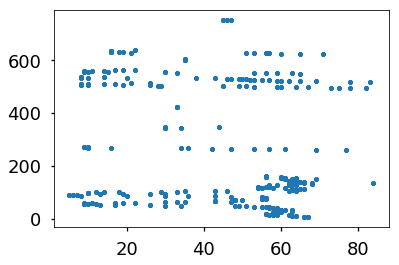

In [35]:
plt.plot(t_cross_vec, x_cross_vec,'.')

In [224]:
pad = 2
p_i = 15
offset = np.sqrt(np.sum(np.power(prox_df.loc[pad,['X', 'Y']].values-cor_pos_df.loc[p_i,['x', 'y']].values,2)))
print(offset)

4985.27104679375


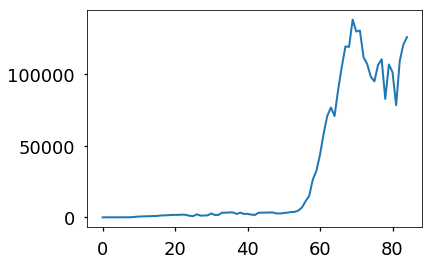

In [238]:
size_vec = im_masks[:,20,:,:].sum(axis=1).sum(axis=1)
plt.plot(size_vec)

(85, 32, 3, 600, 600)


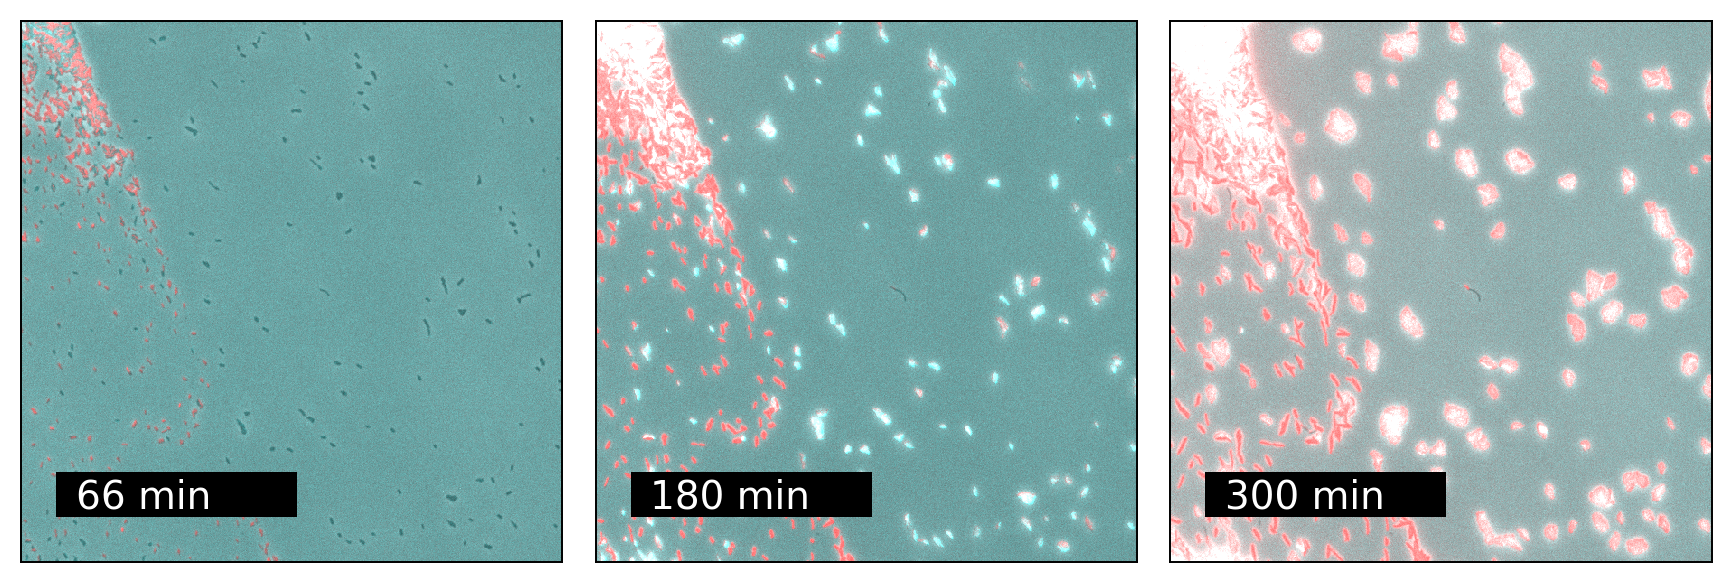

In [22]:
im_all.shape
# anim = write_movie(im_all, skip=40)
# HTML(anim.to_html5_video())
plt.close('all')

im_arr = im_all[:,:,:,200:800,200:800]
print(im_arr.shape)
t, s, c, h, w = im_arr.shape 
im_out = np.zeros((t,3,h,w))

# First set up the figure, the axis, and the plot element we want to animate
blank_array = np.zeros([h, w, 3])
gray_array = np.ones([h, w, 3])
red_array = np.zeros([h, w, 3])
red_array[:,:,0] = 1#np.ones([h, w])
red_array[:,:,1] = 0#np.ones([h, w]) * 0.0
red_array[:,:,2] = 0#np.ones([h, w]) * 0.0
cyan_array = np.zeros([h, w, 3])
cyan_array[:,:,0] = 0#np.ones([h, w]) * 0.0
cyan_array[:,:,1] = 1#np.ones([h, w]) 
cyan_array[:,:,2] = 1#np.ones([h, w])
fig, axs = plt.subplots(1,3, dpi=175, figsize=(10,4))
im_list = [0,0,0]

# Plot cell densities
ax = axs[0]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Inactive Senders, active propagation')
im_list[0] = im

# Plot nutrient densities
ax = axs[1]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Active Senders, active propagation')
im_list[1] = im

# Plot synthase densities
ax = axs[2]
im = ax.imshow(blank_array, animated=True, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('Active Senders, passive propagation')
im_list[2] = im
#     fig.tight_layout()

#     min_v = [15e3, 100, 100]
#     max_v = [30e3, 5e2, 5e2]

min_v = np.array([2e2,  100, 110])*4
max_v = np.array([1.4e3, 5e2, 3.5e2])*4

# Plot cell densities
ax = axs[0]
i = 11
p_i, p = 13, 0
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[0].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'a)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

# min_v = [5e3,  100, 100]
# max_v = [27e3, 5e2, 5e2]
# Plot nutrient densities
ax = axs[1]
i = 30
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[1].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'b)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

# min_v = [15e3, 100, 100]
# max_v = [30e3, 5e2, 5e2]
# Plot synthase densities
ax = axs[2]
i = 50
frame = np.zeros([h, w, 3])
for c, c_array in enumerate([gray_array, red_array, cyan_array]):
    d_arr = (im_arr[i,p_i,c,:,:] - min_v[c]) / (max_v[c] - min_v[c])
#                 d_arr[d_arr > 1 ] = 1
#                 d_arr[d_arr < 0 ] = 0
    frame[:,:,:] += c_array * np.stack(3*[d_arr], axis=2)
frame[frame > 1 ] = 1
frame[frame < 0 ] = 0
t_x, t_y = np.int(w*0.07)-3,np.int(h*0.9)
frame[t_y-40:t_y+10,t_x:t_x+267] = 0
im_list[2].set_array(frame)
ax.set_yticks([])
# ax.set_yticklabels([r'c)'], size=32)
ax.grid(False)
ax.text(np.int(w*0.1),np.int(h*0.9),
        "{:00d} min".format(i*6),
        size=16,
        color='white',
        bbox=dict(facecolor=None, alpha=0.0))

fig.tight_layout()
fig.savefig("three_stills_large_text.pdf")
fig.savefig("three_stills_large_text.png", dpi=150, transparent=True)


In [6]:
fluo_cols = im_all[:,13:29,2,:,:].sum(axis=2)
col_cols = (im_masks[:,13:29,:,:]>0).sum(axis=2)
normed_arr = fluo_cols / col_cols

/home/jmp/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
im_rshp = normed_arr.reshape((85,16*1024))

In [59]:
fluo_cols = im_all[:,17:,2,:,:].sum(axis=2)
# col_cols = (im_masks[:,2:17,:,:]>0).sum(axis=2)
n_t, n_p, w = fluo_cols.shape
normed_arr = fluo_cols #/ col_cols
im_rshp = normed_arr.reshape((n_t,w*n_p))
ind_arr = np.tile(np.arange(n_t).reshape((n_t,1)),(1,w*n_p))
ind_arr[np.isinf(im_rshp)] = n_t
ind_arr[np.isnan(im_rshp)] = n_t
im_rshp[np.isinf(im_rshp)] = im_rshp.min()
im_rshp[np.isnan(im_rshp)] = im_rshp.min()
thresh = skimage.filters.threshold_li(im_rshp)
ind_arr[im_rshp < thresh] = n_t


In [56]:
cross_vec = ind_arr.min(axis=0)
t_cross_vec = t_df.loc[(t_df.pos == 16),"time"].values - t_df.time.min()
t_cross_vec.sort()
t_cross_vec = np.array([t_cross_vec[xx] for xx in cross_vec if xx < 85])
x_vec = np.concatenate([np.linspace(0,0.768,1024)+cor_pos_df.dist[xx]/1e3 for xx in np.arange(2,17)])
x_cross_vec = np.array([x_vec[xx] for xx in np.arange(w*n_p) if cross_vec[xx] < n_t])
fit_t = t_cross_vec
fit_x = x_cross_vec
def f_fun(p, t=fit_t):
    c0,c1,c2 = p
    return c0 + c1 * np.power(t, c2)

def f_res(p, t=fit_t):
    c0,c1,c2 = p
    if c1 < 0:
        return np.inf
#     if c2 < 0:
#         return np.inf
    res = fit_x - f_fun(p, t)
    return np.sum(res*res)



In [60]:
# fluo_cols = im_all[:,14:29,2,:,:].sum(axis=2)
# col_cols = (im_masks[:,14:29,:,:]>0).sum(axis=2)
# n_t, n_p, w = col_cols.shape
all_arr = im_all[:,17:,2,:,:].sum(axis=2) # / (im_masks[:,14:29,:,:]>0).sum(axis=2)

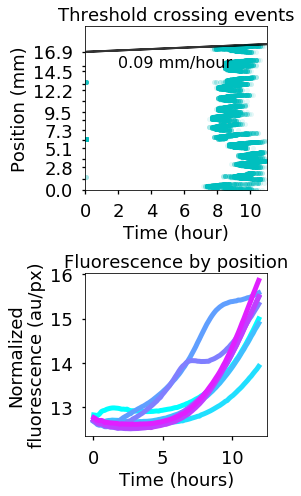

In [61]:
est_slope = (fit_x[-1] - fit_x[0]) / (fit_t[-1] - fit_t[0])
est_y_int = fit_x[0] - fit_t[0]*est_slope
fit_out = opt.minimize(f_res, np.array([est_y_int, est_slope,1]))
fit_p = fit_out.x
fig, axs = plt.subplots(2,1,figsize=(4,7))
plt.sca(axs[0])
plt.plot(t_cross_vec/3600, x_cross_vec,'c.',alpha=0.1,ms=10)
plt.plot(t_cross_vec/3600, f_fun(fit_p),'k',alpha=0.8)
plt.xlim([0,11])
plt.ylim([0,20])
yticks = np.round(cor_pos_df.loc[cor_pos_df.pad==2,'dist'].values/1e3,1)
yticks_labels = np.array(["{}".format(xx) for xx in yticks])
for i in np.arange(len(yticks)):
    if np.mod(i,2) == 1:
        yticks_labels[i] = ""
_ = plt.yticks(yticks, yticks_labels)
plt.xticks(np.arange(0,11,2))
plt.text(2,15,"{:0.2f} mm/hour".format(fit_p[1]*3600),fontsize=16)
plt.ylabel('Position (mm)')
plt.xlabel('Time (hour)')
plt.title('Threshold crossing events',fontsize=18)
plt.sca(axs[1])
t_vec = t_df.loc[(t_df.pos == 16),"time"].values - t_df.time.min()
cmap = plt.get_cmap('cool')

lines = plt.plot(t_vec/3600, all_arr[:,::2,:].sum(axis=2)/6e7, lw=5)
# lines = plt.plot(t_vec/3600, all_arr[:,:8,:].sum(axis=2)/6e7, lw=5)
# plt.plot([0,11],[thresh/1e4,thresh/1e4])
for i, line in enumerate(lines):
    line.set_color(cmap(i/8))
plt.xlabel("Time (hours)")
plt.ylabel("Normalized\nfluorescence (au/px)")
plt.title('Fluorescence by position',fontsize=18)
plt.tight_layout()
plt.savefig('full_thresh.png', transparent=True, bbox_inches='tight')
plt.savefig('full_thresh.pdf', transparent=True)

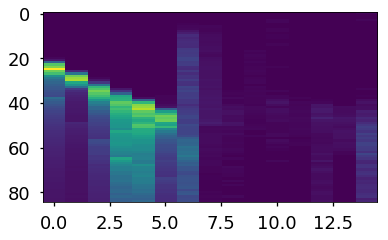

In [204]:
all_arr[np.isinf(all_arr)] = 0
plt.imshow(all_arr[:,:,:].sum(axis=2),aspect=1/10)